### Bayesian Optimization Application
- hyperparameter tuning 과정에서 Bayesian Optimization 사용되는 과정 살펴보기
- XGBoost 와 GPyOpt 패키지를 사용해서 모델 적합 과정에서 Bayesian Optimization을 어떻게 사용하는지 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [89]:
bounds = np.array([[-3.0,4.0]])
noise = 0.2

def func(x, noise = noise) :
    return np.sin(x) + noise*np.random.randn(*x.shape)

x_tr = np.array([[-0.9],[1.4]])
y_tr = func(x_tr)

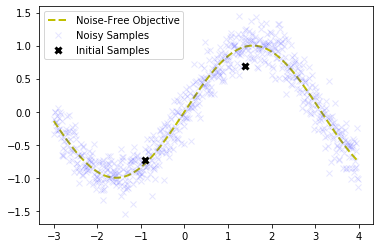

In [90]:
x = np.arange(bounds[:,0], bounds[:,1], 0.01).reshape(-1,1)
y = func(x,0)

plt.plot(x,y, 'y--', lw = 2, label = 'Noise-Free Objective')
plt.plot(x, func(x), 'bx', lw = 1, alpha = 0.1, label = 'Noisy Samples')
plt.plot(x_tr, y_tr, 'kx', mew = 3, label = 'Initial Samples')
plt.legend()

In [91]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [92]:
kernel = GPy.kern.RBF(input_dim = 1, variance = 1.0, lengthscale = 1.0)

In [93]:
bds = [
    {'name' : 'x'
    ,'type' : 'continuous'
    ,'domain' : bounds.ravel()}]

In [94]:
optimizer = BayesianOptimization(f = func
                                , domain = bds
                                , model_type = 'GP'
                                , kernel = kernel
                                , acquisition_type = 'EI'
                                , acquisition_jitter = 0.01
                                , x = x_tr
                                , y = y_tr
                                , noise_var = noise**2
                                , exact_feval = False
                                , normalize_Y = False
                                , maximize = True)

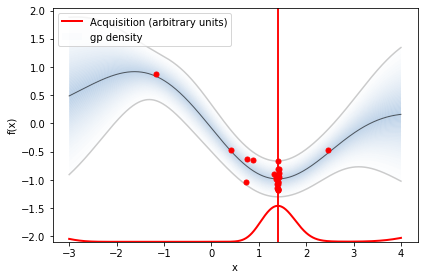

In [95]:
optimizer.run_optimization(max_iter = 20)
optimizer.plot_acquisition()

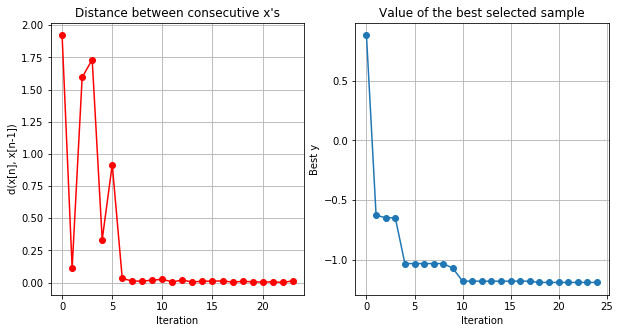

In [104]:
optimizer.plot_convergence()

In [109]:
-optimizer.get_evaluations()[1]

array([[-0.87778303],
       [ 0.62433597],
       [ 0.64619461],
       [ 0.4747667 ],
       [ 1.02866925],
       [ 0.47256714],
       [ 0.89960515],
       [ 0.94305448],
       [ 0.97679581],
       [ 1.06824159],
       [ 1.17568531],
       [ 0.95421868],
       [ 0.80212359],
       [ 0.91037101],
       [ 1.14089253],
       [ 1.16039563],
       [ 0.79941209],
       [ 1.07964953],
       [ 1.18632259],
       [ 0.8748533 ],
       [ 0.91503437],
       [ 1.16445282],
       [ 1.04070931],
       [ 0.65656568],
       [ 1.04448423]])

In [33]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from scipy.stats import uniform
from xgboost import XGBRegressor

In [34]:
x, y = datasets.load_diabetes(return_X_y = True)

In [37]:
xgb = XGBRegressor()
baseline = cross_val_score(xgb, x, y, scoring = 'neg_mean_squared_error').mean()

[23:13:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:13:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:13:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:13:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:13:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


- Hyperparameter를 탐색할 Space에 대한 사전 정의

In [40]:
params_dist = {
    'learning_rate' : uniform(0,1),
    'gamma' : uniform(0,5),
    'max_depth' : range(1,50),
    'n_estimators' : range(1,300),
    'min_child_weight' : range(1,10)    
}

- Random Search를 이용한 Hyperparameter tuning 

In [43]:
rs = RandomizedSearchCV(xgb, param_distributions = params_dist, scoring = 'neg_mean_squared_error', n_iter = 20)

rs.fit(x,y)

[23:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:13] WARNI

[23:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:23] WARNI

[23:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(estimator=XGBRegressor(), n_iter=20,
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000015AA8FE3B70>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000015AA8FE3668>,
                                        'max_depth': range(1, 50),
                                        'min_child_weight': range(1, 10),
                                        'n_estimators': range(1, 300)},
                   scoring='neg_mean_squared_error')

- Bayesian Optimization을 이용한 Hyperparameter tuning
- hyperparameter에 대한 boundary 설정

In [53]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [50]:
bounds = [
    {'name' : 'learning_rate', 'type' : 'continuous', 'domain' : (0,1)},
    {'name' : 'gamma', 'type' : 'continuous', 'domain' : (0,5)},
    {'name' : 'max_depth', 'type' : 'discrete', 'domain' : (1,50)},
    {'name' : 'n_estimators', 'type' : 'discrete', 'domain' : (1,300)},
    {'name' : 'min_child_weight', 'type' : 'discrete', 'domain' : (1,10)}    
]

- Optimization이 필요한 objective function에 대한 정의

In [51]:
def cv_score(parameters) : 
    parameters = parameters[0]
    score = cross_val_score(XGBRegressor(learning_rate = parameters[0],
                                         gamma = int(parameters[1]),
                                         max_depth = int(parameters[2]),
                                         n_estimators = int(parameters[3]),
                                         min_child_weight = parameters[4]),
                            x, y, scoring = 'neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [54]:
optimizer = BayesianOptimization(f = cv_score,
                                 domain = bounds,
                                 model_type = "GP",
                                 acquisition_type = "EI",
                                 acquisition_jitter = 0.05,
                                 exact_feval = True,
                                 maximize = True)

[23:36:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:24] WARNI

In [55]:
optimizer.run_optimization(max_iter = 20)

[23:36:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:48] WARNI

[23:37:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:02] WARNI

In [60]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

array([[ 4565.18729588],
       [ 4194.64866505],
       [22256.00395574],
       [ 5305.52448944],
       [ 4815.47280021],
       [28927.84356486],
       [28927.84356486],
       [28927.84356486],
       [ 4599.89459912],
       [28927.84356486],
       [ 4265.66014232],
       [ 4767.6536673 ],
       [28927.84356486],
       [ 4767.6536673 ],
       [ 5162.62868338],
       [28927.84356486],
       [ 4880.72383792],
       [ 4095.79442724],
       [11366.50004264],
       [ 5694.37390433],
       [ 3973.869456  ],
       [ 3954.72714544],
       [ 4352.16057791],
       [28927.84356486],
       [ 5108.53440047]])